In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import seaborn as sns
from scipy.ndimage import rotate, zoom
from matplotlib.patches import Rectangle

In [2]:
from skimage import measure
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [5]:
# Get image numbers from train_images/authentic
authentic_path = "data/train_images/authentic"
authentic_files = glob.glob(os.path.join(authentic_path, "*.png"))
authentic_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in authentic_files]))

# Get image numbers from train_images/forged
forged_path = "data/train_images/forged"
forged_files = glob.glob(os.path.join(forged_path, "*.png"))
forged_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in forged_files]))

# Get image numbers from supplemental_images
supplemental_path = "data/supplemental_images"
supplemental_files = glob.glob(os.path.join(supplemental_path, "*.png"))
supplemental_nums = np.array(sorted([int(os.path.basename(f).replace(".png", "")) for f in supplemental_files]))

# Get train masks
train_masks_path = "data/train_masks"
train_masks = glob.glob(os.path.join(train_masks_path, "*.npy"))

# Get supplemental masks
supplemental_masks_path = "data/supplemental_masks"
supplemental_masks = glob.glob(os.path.join(supplemental_masks_path, "*.npy"))

print(f"Authentic images: {len(authentic_nums)}")
print(f"Forged images: {len(forged_nums)}")
print(f"Supplemental images: {len(supplemental_nums)}")

Authentic images: 2377
Forged images: 2751
Supplemental images: 48


In [7]:
mask = np.load(train_masks[4])
print(mask.shape, mask.dtype, np.unique(mask))

(3, 1105, 1105) uint8 [0 1]


In [7]:
rows = []
property_list = ["area", "area_bbox", "eccentricity", "euler_number", 
                 "extent", "inertia_tensor", "inertia_tensor_eigvals", "moments_hu"]

counter = 0
for mask_path in train_masks:
    mask = np.load(mask_path).squeeze()

    # Case 1: single 2D mask
    if mask.ndim == 2:
        channel_list = [mask]
        channel_names = [""]
    
    # Case 2: multi-channel mask of shape (C, H, W)
    elif mask.ndim == 3:
        C = mask.shape[0]
        channel_list = [mask[i].squeeze() for i in range(C)]
        channel_names = [f"_channel{i}" for i in range(C)]
    
    else:
        raise ValueError(f"Unexpected mask dimensions {mask.shape}. Expected 2D or (C,H,W).")

    # Process all channels independently
    for chan_mask, chan_name in zip(channel_list, channel_names):

        # Safety: each channel must be 2D
        if chan_mask.ndim != 2:
            raise ValueError(f"Channel not 2D after squeeze: {chan_mask.shape} from file {mask_path}")

        labeled = measure.label(chan_mask)

        props = measure.regionprops_table(labeled, properties=property_list)
        df_props = pd.DataFrame(props)

        # include the mask filename + channel suffix
        base = os.path.basename(mask_path)
        df_props["mask_name"] = base + chan_name

        rows.append(df_props)
        
    if counter % 100 == 0:
        print("processed mask ", counter)
    
    counter += 1

# concatenate into single df
regionprops_df = pd.concat(rows, ignore_index=True)

regionprops_df

processed mask  0
processed mask  100
processed mask  200
processed mask  300
processed mask  400
processed mask  500
processed mask  600
processed mask  700
processed mask  800
processed mask  900
processed mask  1000
processed mask  1100
processed mask  1200
processed mask  1300
processed mask  1400
processed mask  1500
processed mask  1600
processed mask  1700
processed mask  1800
processed mask  1900
processed mask  2000
processed mask  2100
processed mask  2200
processed mask  2300
processed mask  2400
processed mask  2500
processed mask  2600
processed mask  2700


,area,area_bbox,eccentricity,euler_number,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,mask_name
0,250.0,360.0,0.464544,1,0.694444,19.371904,-2.186944,-2.186944,21.736384,23.040188,18.068100,0.164433,0.000396,0.000241,0.000002,1.882607e-11,3.256341e-08,4.131215e-11,48280.npy
1,274.0,360.0,0.475075,1,0.761111,19.684799,0.122756,0.122756,25.416551,25.419179,19.682172,0.164603,0.000438,0.000244,0.000002,3.088980e-11,4.291634e-08,4.903545e-11,48280.npy
2,224.0,340.0,0.470554,1,0.658824,20.294324,1.456075,1.456075,16.722716,20.812701,16.204339,0.165255,0.000423,0.000255,0.000003,4.585435e-11,5.115044e-08,5.398402e-11,48280.npy
3,26188.0,31122.0,0.830833,1,0.841463,1183.209239,-151.992653,-151.992653,3782.852083,3791.708428,1174.352895,0.189631,0.009989,0.000056,0.000003,3.899565e-11,2.903234e-07,1.512884e-11,8081.npy
4,23868.0,28956.0,0.835328,1,0.824285,1066.933540,-142.648178,-142.648178,3494.231684,3502.586120,1058.579104,0.191100,0.010485,0.000066,0.000004,5.463008e-11,3.555251e-07,1.976421e-11,8081.npy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8632,73.0,99.0,0.775986,1,0.737374,5.710640,-2.680240,-2.680240,7.212235,9.244850,3.678025,0.177026,0.005815,0.000031,0.000003,3.206492e-11,2.563307e-07,1.671775e-11,36035.npy
8633,4348.0,11457.0,0.966538,1,0.379506,1828.254770,49.663832,49.663832,121.846749,1829.698979,120.402539,0.448505,0.154545,0.055803,0.044269,2.200131e-03,1.715064e-02,-2.235900e-05,64773.npy
8634,4403.0,16235.0,0.966648,-2,0.271204,299.397069,-525.891287,-525.891287,1678.621483,1856.261628,121.756924,0.449243,0.155186,0.055666,0.044194,2.191865e-03,1.715651e-02,-2.178004e-05,64773.npy
8635,1846.0,1846.0,0.930630,1,1.000000,420.000000,-0.000000,-0.000000,56.250000,420.000000,56.250000,0.257990,0.038828,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,32535.npy


In [8]:
regionprops_df.to_csv("regionprops_df.csv")

In [9]:
df_std = regionprops_df.copy()

numeric_cols = df_std.select_dtypes(include="number").columns

# standardize
scaler = StandardScaler()
df_std[numeric_cols] = scaler.fit_transform(df_std[numeric_cols])

df_std.head()

,area,area_bbox,eccentricity,euler_number,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,mask_name
0,-0.314511,-0.312878,-1.216074,0.142354,-0.302308,-0.188495,-0.006111,-0.006111,-0.210289,-0.255255,-0.374137,-0.645102,-0.444716,-0.148129,-0.099738,-0.032198,-0.060796,0.008503,48280.npy
1,-0.313933,-0.312878,-1.166638,0.142354,0.118559,-0.188463,-0.003952,-0.003952,-0.209926,-0.255084,-0.372677,-0.642961,-0.443928,-0.147479,-0.099624,-0.032198,-0.060791,0.008503,48280.npy
2,-0.315137,-0.313236,-1.187861,0.142354,-0.527182,-0.188400,-0.002705,-0.002705,-0.210784,-0.255416,-0.375823,-0.634776,-0.444206,-0.145191,-0.099526,-0.032198,-0.060786,0.008503,48280.npy
3,0.310010,0.237948,0.503376,0.142354,0.625818,-0.068604,-0.146182,-0.146182,0.160866,0.015942,0.671678,-0.328347,-0.268209,-0.186415,-0.099381,-0.032198,-0.060657,0.008502,8081.npy
4,0.254151,0.199163,0.524473,0.142354,0.517376,-0.080582,-0.137445,-0.137445,0.132384,-0.004863,0.566965,-0.309888,-0.259081,-0.184368,-0.099199,-0.032198,-0.060622,0.008502,8081.npy


In [10]:
df_std.to_csv("regionprops_df_norm.csv")

In [41]:
cluster_df = df_std.copy()

# Select numerical columns for clustering
feature_cols = cluster_df.select_dtypes(include="number").columns

X = cluster_df[feature_cols].values

# ----- Fit Gaussian Mixture Model -----
n_components = 7

gmm = GaussianMixture(
    n_components=n_components,
    covariance_type="full",
    random_state=42
)

gmm.fit(X)

# Cluster assignments
cluster_df["gmm_cluster"] = gmm.predict(X)

cluster_df.head()

,area,area_bbox,eccentricity,euler_number,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,inertia_tensor_eigvals-0,inertia_tensor_eigvals-1,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,mask_name,gmm_cluster
0,-0.314511,-0.312878,-1.216074,0.142354,-0.302308,-0.188495,-0.006111,-0.006111,-0.210289,-0.255255,-0.374137,-0.645102,-0.444716,-0.148129,-0.099738,-0.032198,-0.060796,0.008503,48280.npy,0
1,-0.313933,-0.312878,-1.166638,0.142354,0.118559,-0.188463,-0.003952,-0.003952,-0.209926,-0.255084,-0.372677,-0.642961,-0.443928,-0.147479,-0.099624,-0.032198,-0.060791,0.008503,48280.npy,0
2,-0.315137,-0.313236,-1.187861,0.142354,-0.527182,-0.188400,-0.002705,-0.002705,-0.210784,-0.255416,-0.375823,-0.634776,-0.444206,-0.145191,-0.099526,-0.032198,-0.060786,0.008503,48280.npy,0
3,0.310010,0.237948,0.503376,0.142354,0.625818,-0.068604,-0.146182,-0.146182,0.160866,0.015942,0.671678,-0.328347,-0.268209,-0.186415,-0.099381,-0.032198,-0.060657,0.008502,8081.npy,5
4,0.254151,0.199163,0.524473,0.142354,0.517376,-0.080582,-0.137445,-0.137445,0.132384,-0.004863,0.566965,-0.309888,-0.259081,-0.184368,-0.099199,-0.032198,-0.060622,0.008502,8081.npy,5


In [43]:
cluster_df["gmm_cluster"].value_counts()

gmm_cluster
0    4737
5    2490
3     741
1     643
4      19
2       6
6       1
Name: count, dtype: int64

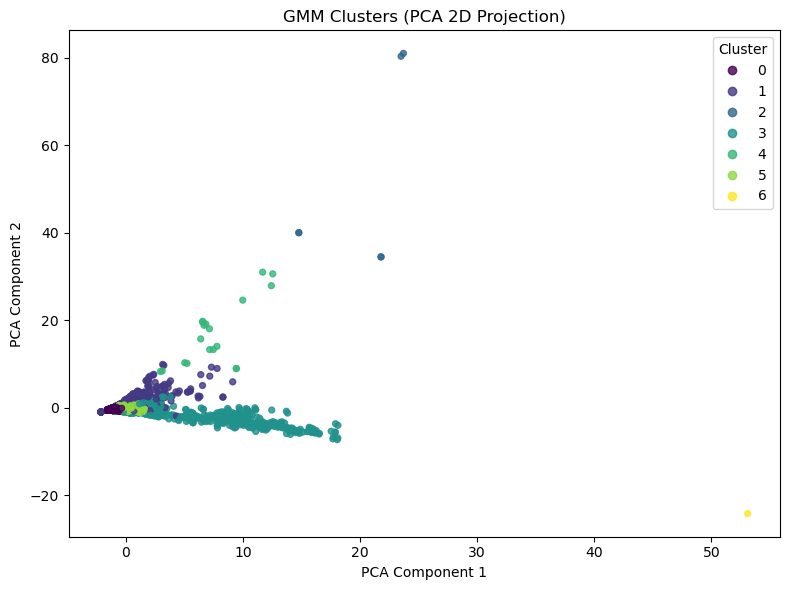

In [45]:
# Select numeric columns except the cluster label
numeric_cols = cluster_df.select_dtypes(include="number").columns
feature_cols = [c for c in numeric_cols if c != "gmm_cluster"]

X = cluster_df[feature_cols].values
y = cluster_df["gmm_cluster"].values

# ---- PCA to 2D ----
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)

# ---- Plot ----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=y, 
    s=18, 
    alpha=0.8
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Clusters (PCA 2D Projection)")

# Legend with cluster labels
plt.legend(*scatter.legend_elements(), title="Cluster")

plt.tight_layout()
plt.show()

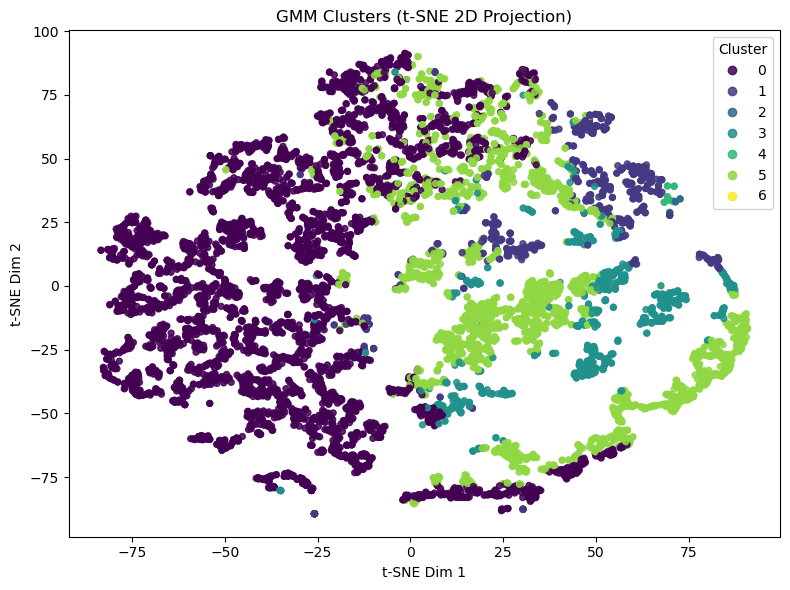

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Features for t-SNE (exclude cluster label)
numeric_cols = cluster_df.select_dtypes(include="number").columns
feature_cols = [c for c in numeric_cols if c != "gmm_cluster"]

X = cluster_df[feature_cols].values
y = cluster_df["gmm_cluster"].values

# ----- Fit t-SNE -----
tsne = TSNE(
    n_components=2,
    perplexity=30,      # typical values: 5–50
    learning_rate=200,  # default 200
    random_state=0
)

X_tsne = tsne.fit_transform(X)

# ----- Plot -----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    s=18,
    alpha=0.85
)

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("GMM Clusters (t-SNE 2D Projection)")

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

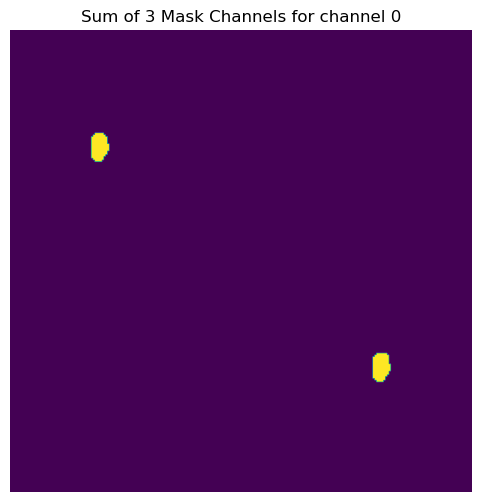

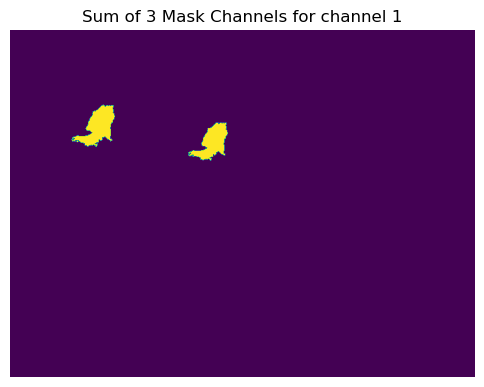

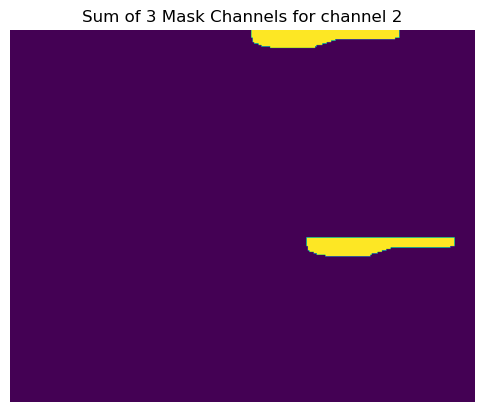

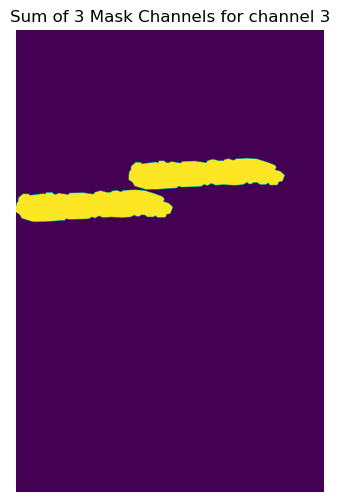

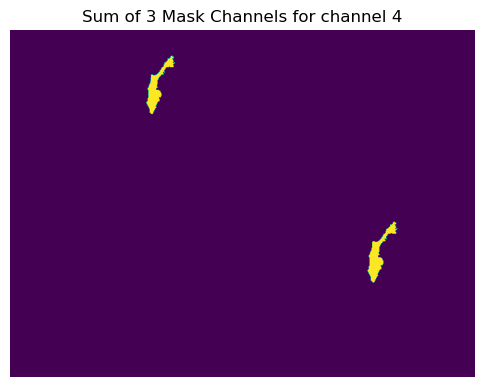

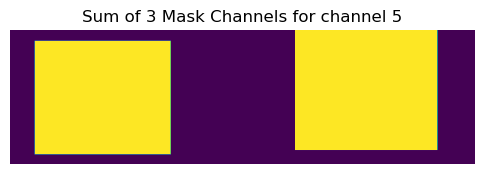

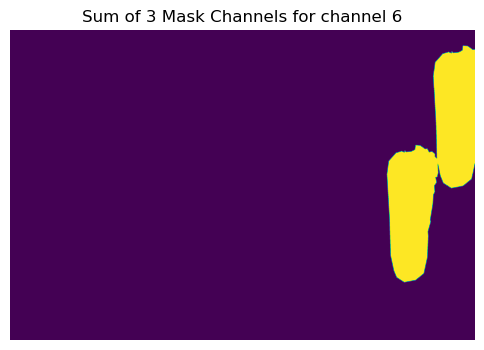

In [51]:
for c in range(n_components):
    c_df = cluster_df[cluster_df["gmm_cluster"] == c]
    flag = False
    try:
        c_df = c_df[~c_df["mask_name"].str.contains("channel")]
        c_sample = train_masks_path + "/" + c_df["mask_name"].sample(1).values[0]
        c_masks = np.load(c_sample).squeeze()
        plt.figure(figsize=(6,6))
        plt.imshow(c_masks)
        plt.title(f"Sum of 3 Mask Channels for channel {c}")
        plt.axis('off')
        plt.show()
        flag = True
    except:
        pass

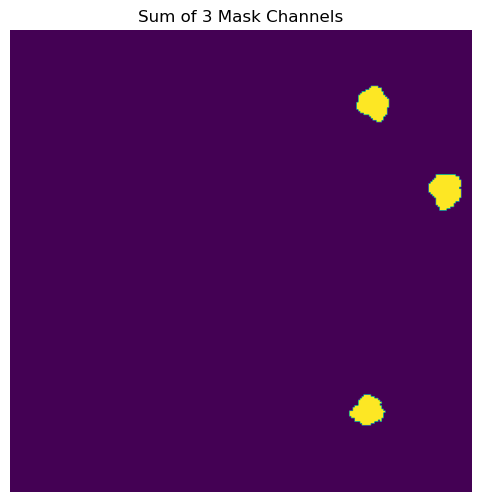

In [115]:
m = np.load(train_masks[0])    

mask_sum = m.sum(axis=0)       

plt.figure(figsize=(6,6))
plt.imshow(mask_sum)
plt.title("Sum of 3 Mask Channels")
plt.axis('off')
plt.show()

In [99]:
def resize_and_pad_image(img: Image.Image, target=512):
    """
    Rotate so longest side is horizontal, resize longest side to target,
    then pad shorter side to target. Works for RGB/Grayscale images.
    """
    # Convert to RGB if needed
    if img.mode not in ["RGB", "RGBA", "L"]:
        img = img.convert("RGB")

    w, h = img.size

    # Rotate if height > width (tall image)
    if h > w:
        img = img.rotate(90, expand=True)
        w, h = img.size

    # Scale long side to target=512
    scale = target / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    img = img.resize((new_w, new_h), Image.BILINEAR)

    # Pad to 512 x 512
    pad_w = (target - new_w) // 2
    pad_h = (target - new_h) // 2

    # Create padded canvas (black)
    new_img = Image.new(img.mode, (target, target))
    new_img.paste(img, (pad_w, pad_h))

    return new_img

In [100]:
def resize_and_pad_mask(mask: np.ndarray, target=512):
    """
    Rotate so long side is horizontal, resize longest side to target,
    then pad shorter side to target. Uses nearest-neighbor interpolation.
    mask: H x W (or H x W x C label array)
    """
    h, w = mask.shape[:2]

    # Rotate if height > width
    if h > w:
        # rotate 90 degrees CCW; nearest interpolation
        mask = rotate(mask, 90, reshape=True, order=0)
        h, w = mask.shape[:2]

    # Scale long side
    scale = target / max(w, h)
    zoom_factors = (scale, scale) + ((1,) if mask.ndim == 3 else ())
    mask = zoom(mask, zoom_factors, order=0)

    new_h, new_w = mask.shape[:2]

    # Create padded 512x512 mask
    padded = np.zeros((target, target) + (() if mask.ndim == 2 else (mask.shape[2],)),
                      dtype=mask.dtype)

    pad_h = (target - new_h) // 2
    pad_w = (target - new_w) // 2

    padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = mask

    return padded

In [101]:
def get_bounding_boxes_with_margin(mask, margin=1):
    """
    Find the smallest bounding boxes that surround all connected components in a mask,
    with an added margin around each box.
    
    Args:
        mask: Binary mask array (2D numpy array with 1s and 0s)
        margin: Margin to add around each bounding box (default: 1)
    
    Returns:
        Array of bounding boxes, each as [min_row, min_col, max_row, max_col]
        Returns empty array if no components found
    """
    # Ensure mask is binary
    mask_bin = (mask > 0).astype(np.uint8)
    
    # Find connected components (islands of 1s)
    labeled_mask, num_features = ndimage.label(mask_bin)
    
    if num_features == 0:
        return np.array([]).reshape(0, 4)
    
    # Get bounding boxes for each component efficiently
    # find_objects returns a list of slice objects, one per component
    slices = ndimage.find_objects(labeled_mask)
    
    boxes = []
    H, W = mask_bin.shape
    
    for slice_obj in slices:
        if slice_obj is None:
            continue
            
        row_slice, col_slice = slice_obj
        
        # Get bounding box coordinates
        min_row = row_slice.start
        max_row = row_slice.stop - 1  # stop is exclusive, so subtract 1
        min_col = col_slice.start
        max_col = col_slice.stop - 1
        
        # Add margin, clamping to image boundaries
        min_row = max(0, min_row - margin)
        min_col = max(0, min_col - margin)
        max_row = min(H - 1, max_row + margin)
        max_col = min(W - 1, max_col + margin)
        
        boxes.append([min_row, min_col, max_row, max_col])
    
    return np.array(boxes)


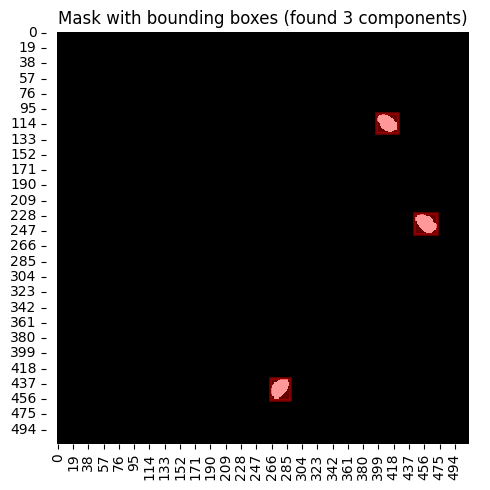

In [173]:
# Plot bounding box over masks

mask_choice = np.random.choice(train_masks)
mask = resize_and_pad_mask(np.load(mask_choice)[0])

# Get bounding boxes
boxes = get_bounding_boxes_with_margin(mask)

# Plot mask
plt.figure(figsize=(5, 5))
sns.heatmap(mask, cmap='gray', cbar=False)

# Plot each bounding box with alpha=0.4

for box in boxes:
    min_row, min_col, max_row, max_col = box
    
    # Draw rectangle
    width = max_col - min_col + 1
    height = max_row - min_row + 1
    
    rect = Rectangle((min_col, min_row), width, height, 
                     linewidth=2, edgecolor='red', facecolor='red', alpha=0.4)
    plt.gca().add_patch(rect)

plt.title(f'Mask with bounding boxes (found {len(boxes)} components)')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
from skimage.measure.regionprops import regionprops

#TODO